In [70]:
#from airflow.providers.postgres.hooks.postgres import PostgresHook
from sqlalchemy import create_engine, select, text
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#from dags.module.info.connections import Connections

#import sys
#import os

# module_path = '/home/ubuntu/MLOps-project'
# if module_path not in sys.path:
#     sys.path.append(module_path)


In [71]:
# PostgreSQL 연결 정보를 환경 변수에서 가져옵니다.
#postgres_hook = PostgresHook(postgres_conn_id=Connections.POSTGRES_DEFAULT.value)
# 데이터베이스 연결 엔진을 생성합니다.
engine = create_engine('postgresql://postgres:@:5432')


In [72]:
# 세션을 생성하여 데이터베이스 연결
with Session(bind=engine) as session:
    query = text("SELECT * FROM btc_ohlc")
    
    # 쿼리 실행 및 결과를 pandas 데이터프레임으로 변환
    result = session.execute(query)
    df = pd.DataFrame(result.all(), columns=result.keys())
    session.commit()

In [73]:
df.head()

,time,open,high,low,close,volume
0,2023-05-28 12:00:00,36171000,36320000,36165000,36270000,257
1,2023-05-28 13:00:00,36280000,36421000,36270000,36314000,192
2,2023-05-28 14:00:00,36314000,36318000,36218000,36246000,116
3,2023-05-28 15:00:00,36246000,36355000,36246000,36318000,103
4,2023-05-28 16:00:00,36298000,36380000,36298000,36355000,80


In [75]:
df.info()     # non-null한 데이터. time 제외하고 int타입

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    8785 non-null   datetime64[ns]
 1   open    8785 non-null   int64         
 2   high    8785 non-null   int64         
 3   low     8785 non-null   int64         
 4   close   8785 non-null   int64         
 5   volume  8785 non-null   int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 411.9 KB


In [76]:
df.isnull().sum() 

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [77]:
df.describe()  # open,high,low,close 중에 0인 값이 있거나, 이상치로 느껴지는 부분은 없는 것 같다. volume 분포 확인필요

,time,open,high,low,close,volume
count,8785,8.785000e+03,8.785000e+03,8.785000e+03,8.785000e+03,8785.000000
mean,2023-11-27 12:00:00,5.821274e+07,5.839310e+07,5.803275e+07,5.821831e+07,188.911895
min,2023-05-28 12:00:00,3.258800e+07,3.267900e+07,3.251000e+07,3.258800e+07,0.000000
25%,2023-08-28 00:00:00,3.807600e+07,3.816600e+07,3.798900e+07,3.807700e+07,74.000000
50%,2023-11-27 12:00:00,5.050800e+07,5.057300e+07,5.042600e+07,5.051000e+07,123.000000
75%,2024-02-27 00:00:00,7.249000e+07,7.310000e+07,7.223500e+07,7.286600e+07,211.000000
max,2024-05-28 12:00:00,1.048310e+08,1.050000e+08,1.046180e+08,1.048410e+08,6243.000000
std,NaN,2.286362e+07,2.297264e+07,2.275144e+07,2.286645e+07,242.666557


In [78]:
# volume = 0 인 데이터 호출
df[df['volume'] == 0]  # 3개의 데이터 발견.

,time,open,high,low,close,volume
1070,2023-07-12 02:00:00,40283000,40283000,40282000,40282000,0
1742,2023-08-09 02:00:00,39357000,39360000,39356000,39360000,0
7406,2024-04-01 02:00:00,100319000,100350000,100319000,100319000,0


In [79]:
df[df['volume'] > 2000].value_counts()

time                 open       high       low       close     volume
2023-06-30 22:00:00  41260000   41317000   39500000  40218000  2005      1
2023-08-29 23:00:00  35330000   37628000   35330000  37162000  2313      1
2023-10-16 22:00:00  37997000   40700000   37820000  38128000  4465      1
2023-10-24 07:00:00  42638000   45165000   42582000  44364000  2637      1
2023-10-24 11:00:00  45940000   47459000   45798000  46237000  2723      1
2023-12-11 11:00:00  59251000   59280000   57014000  57877000  2580      1
2024-01-03 20:00:00  60345000   60400000   58077000  58300000  2724      1
2024-01-03 21:00:00  58277000   58350000   54346000  58043000  6243      1
2024-01-08 21:00:00  60120000   61118000   59816000  60740000  2295      1
2024-01-10 06:00:00  62733000   64385000   60748000  61234000  2263      1
2024-01-11 07:00:00  62445000   64300000   61968000  64059000  2958      1
2024-01-11 08:00:00  64074000   65000000   62998000  63621000  2745      1
2024-01-11 23:00:00  64556000 

In [80]:
# time 컬럼이 오름차순으로 정렬되어 있는지 확인 (오름차순 : True, 아니면 : False)
is_sorted = df['time'].is_monotonic_increasing
is_sorted # True

True

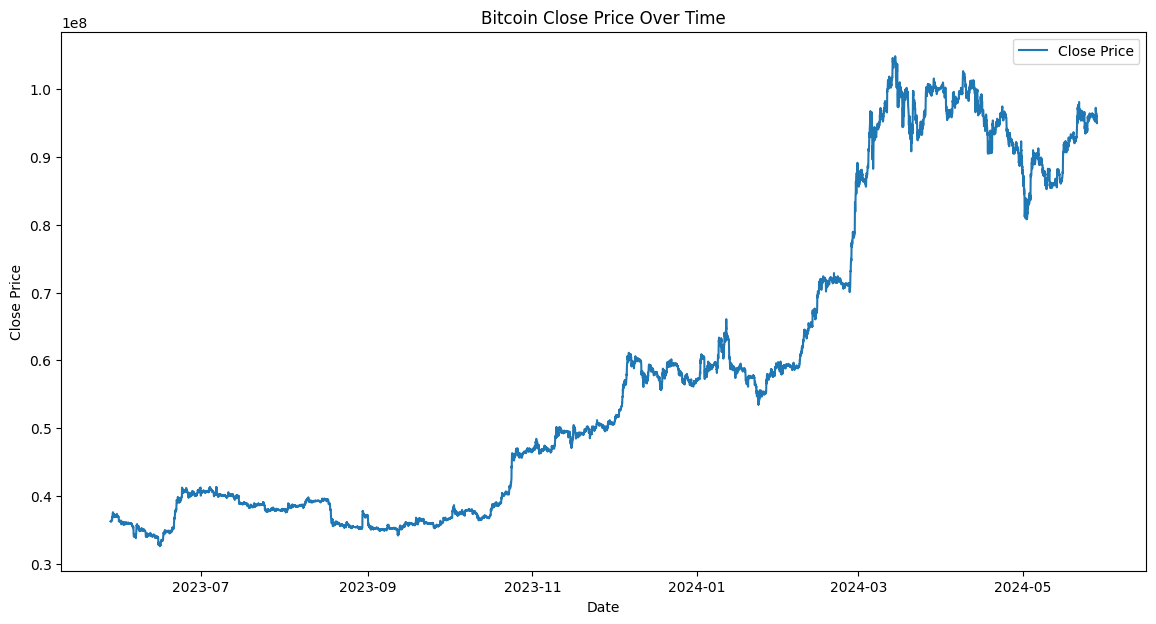

In [81]:
# 시계열 데이터 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.legend()
plt.show()

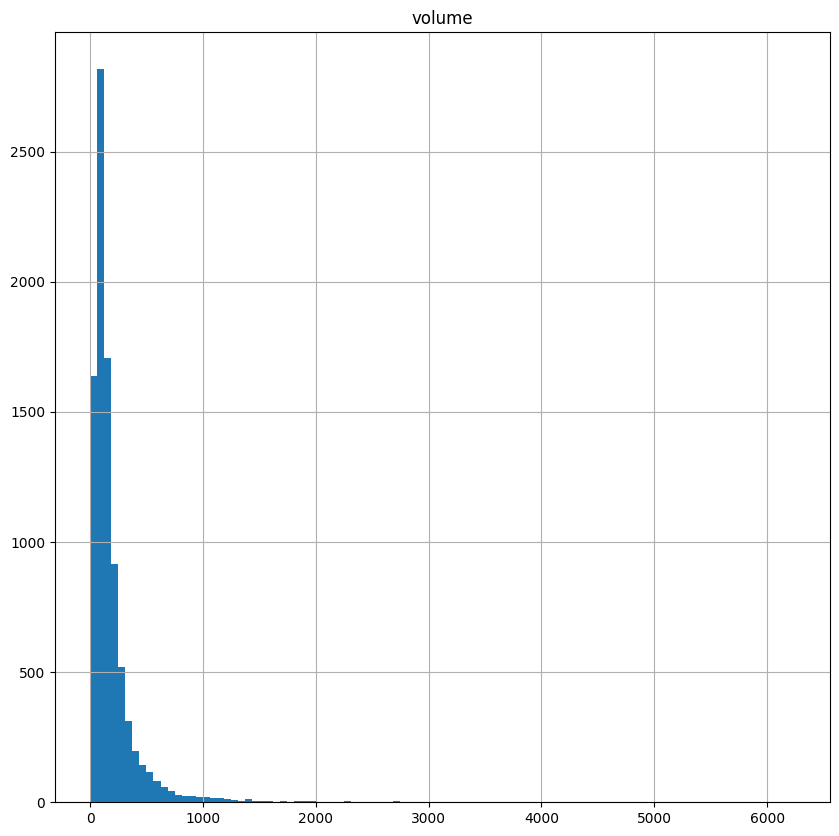

In [95]:
# 히스토그램을 통한 데이터 분포 시각화(volume)  -> skewed 
df.hist('volume', bins=100, figsize=(10, 10))
plt.show()


In [83]:
#  가격 변동성 분석
df['price_diff'] = df['high'] - df['low']
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

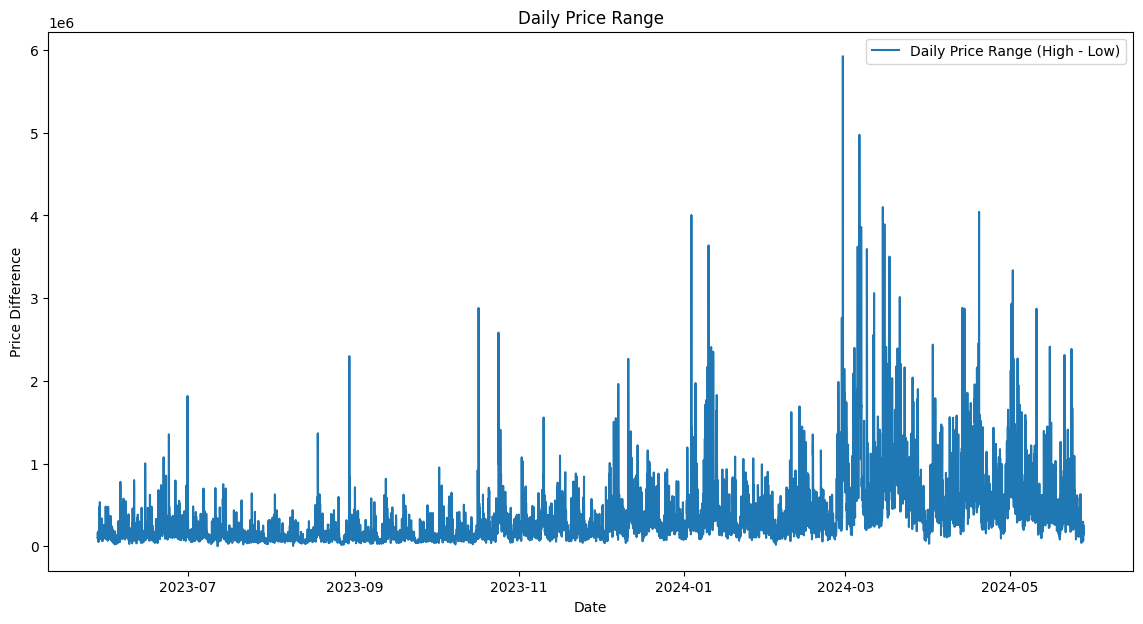

In [84]:
# 일일 변동폭 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['price_diff'], label='Daily Price Range (High - Low)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.title('Daily Price Range')
plt.legend()
plt.show()

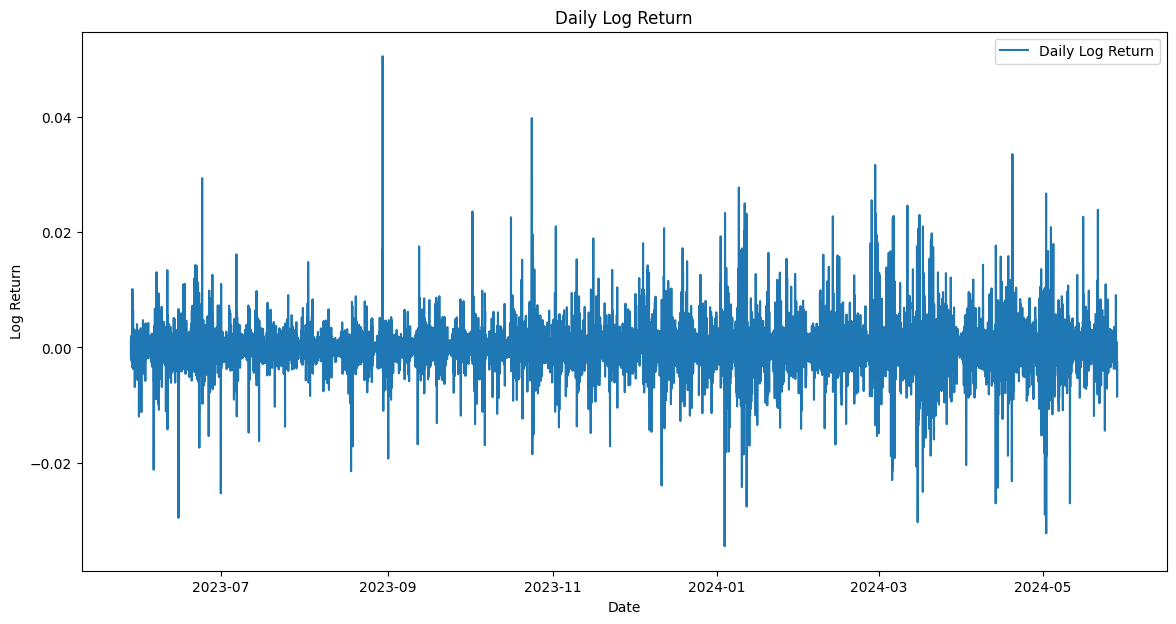

In [85]:
# 일일 로그 수익률 시각화
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['log_return'], label='Daily Log Return')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Daily Log Return')
plt.legend()
plt.show()


In [90]:
df.isnull().sum()

time          0
open          0
high          0
low           0
close         0
volume        0
price_diff    0
log_return    1
dtype: int64

In [94]:
df[df['log_return'].isnull()] # 로그 수익률을 만들 때 shift(1) 을 하기 때문에 첫 행에서 nan값 발생.

,time,open,high,low,close,volume,price_diff,log_return
0,2023-05-28 12:00:00,36171000,36320000,36165000,36270000,257,155000,NaN


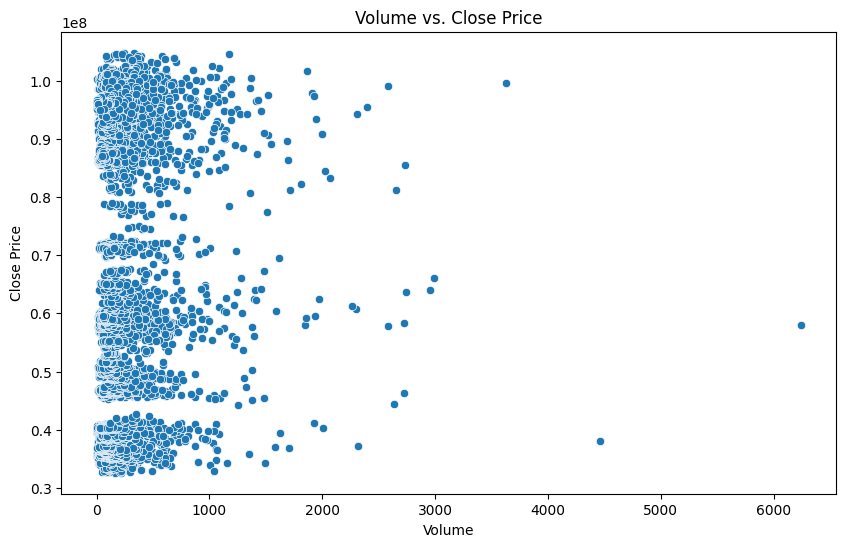

In [86]:
#  거래량과 가격의 관계 분석
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['volume'], y=df['close'])
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('Volume vs. Close Price')
plt.show()

Correlation Matrix:
              volume     close  price_diff  log_return
volume      1.000000  0.170362    0.720028   -0.004717
close       0.170362  1.000000    0.556925    0.009445
price_diff  0.720028  0.556925    1.000000    0.011583
log_return -0.004717  0.009445    0.011583    1.000000


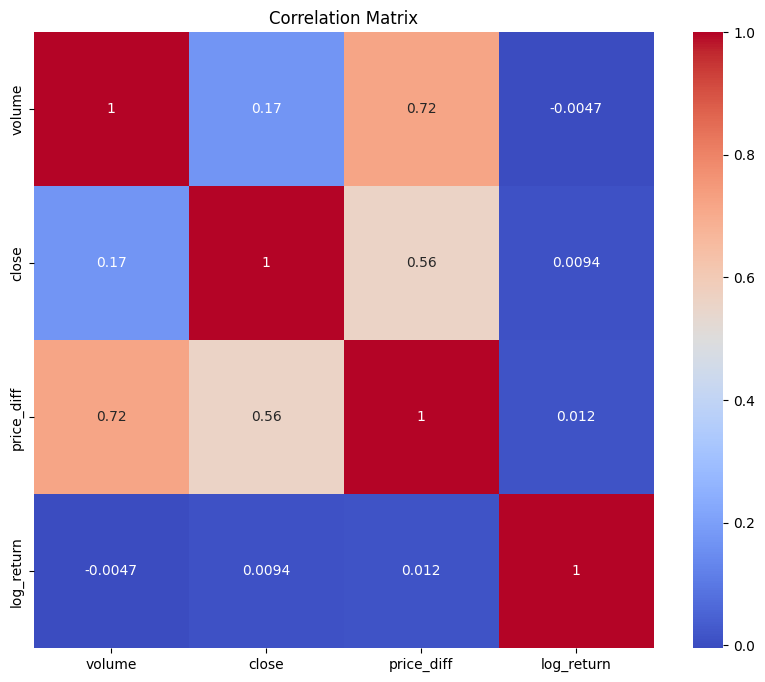

In [87]:
# 상관관계 계산
correlation = df[['volume', 'close', 'price_diff', 'log_return']].corr()
print("Correlation Matrix:")
print(correlation)

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


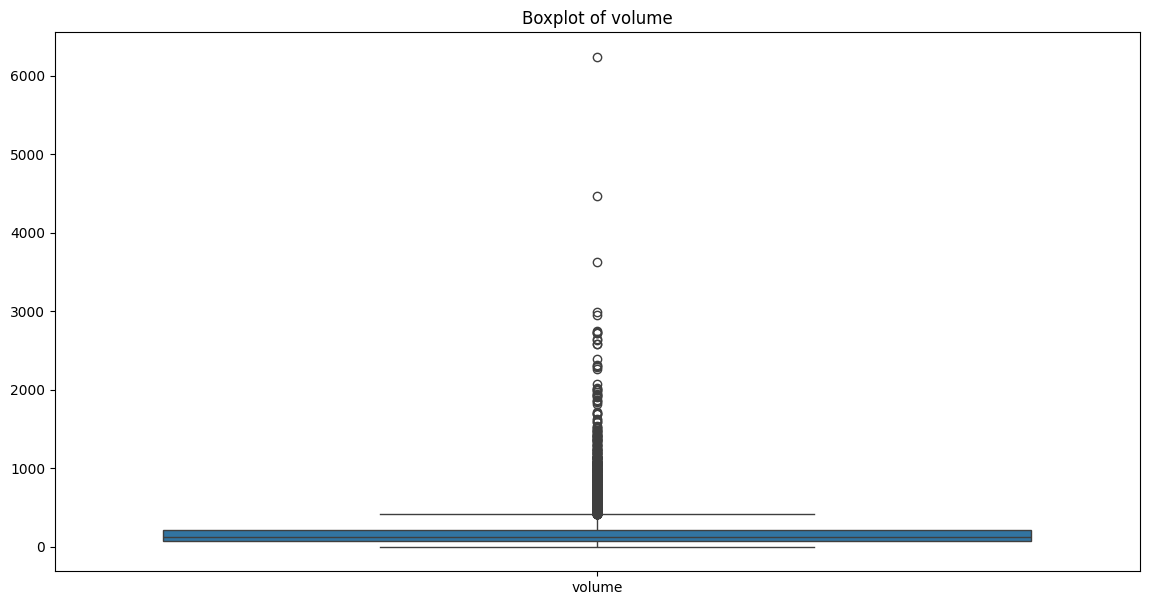

In [88]:
# 박스플롯을 통한 이상치 확인 (volume)
plt.figure(figsize=(14, 7))
sns.boxplot(data=df[['volume']])
plt.title('Boxplot of volume')
plt.show()


In [89]:
df.head()

,time,open,high,low,close,volume,price_diff,log_return
0,2023-05-28 12:00:00,36171000,36320000,36165000,36270000,257,155000,NaN
1,2023-05-28 13:00:00,36280000,36421000,36270000,36314000,192,151000,0.001212
2,2023-05-28 14:00:00,36314000,36318000,36218000,36246000,116,100000,-0.001874
3,2023-05-28 15:00:00,36246000,36355000,36246000,36318000,103,109000,0.001984
4,2023-05-28 16:00:00,36298000,36380000,36298000,36355000,80,82000,0.001018


In [ ]:
'''
eda 결과
전체적으로 결측치는 존재하지 않았고, 시간순으로 잘 정렬되어있다.
거래량과 가격의 상관관계는 크지 않았다. 
volume 컬럼에서 0인 데이터가 3개 발견되었고 이 부분은 삭제하기 보다는 누락되는 시간이 없도록 하기 위해 선형보간법으로 채워줄 예정
volume 컬럼에서 이상치라고 할 수 있는 큰 값들이 존재하긴 하지만 많지 않고, 거래량은 비트코인 특성상 큰 값도 유의미하다고 생각해서
삭제까진 하지 않고,  유지하고 스케일링만 할 예정
가격 변동성을 확인할 수 있는 컬럼을 추가해서 확인해 보았다.
일일 가격 변동폭 : df['price_diff'] = df['high'] - df['low']
일일 로그수익률 : df['log_return'] = np.log(df['close'] / df['close'].shift(1))
여기서 로그수익률 컬럼을 만드는 과정에서 첫번째 인덱스에 nan값이 들어감.
scatterplot 확인결과 대부분의 거래가 거래량이 낮은 거래량(1000이하)에서 이루어지고 있음.
3000 이상을 이상치로 판단하면 될것 같다.


전처리 단계에서 할 일

1. volume = 0 인 컬럼 선형보간법 적용하기
2. volume > 3000 이상인 값은 3000으로 일괄 적용한 후 로그스케일링 적용하기
3. 'price_diff', 'log_return' 컬럼 추가하기
4. time 컬럼은 year, month, day, hour, 등의 피쳐로 나눠서 시간의 주기성을 반영하기 위해 
시간을 24시간을 주기로 사인과 코사인 변환하여 시간대 정보를 캡쳐
'''